# Mask R-CNN for Keypoint Detection

Example showing how to do keypoint detection with Mask R-CNN

In [1]:
USE_GPU = True
TRAIN   = True

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Datasets for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
                        'left_elbow', 'right_elbow', 'left_wrist',
                        'right_wrist', 'left_hip', 'right_hip',
                        'left_knee', 'right_knee', 'left_ankle',
                        'right_ankle']
#keypoints_to_include = ["nose", "right_wrist"]

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/train2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=6.77s)
creating index...
index created!
Will use images in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/val2017
Will use annotations in /datasets/home/78/378/cs252cas/Pose_RCNN/data/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


### Setup Training

In [3]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 100 if USE_GPU else 10
    
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 1
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Train

In [4]:
if TRAIN:
    importlib.reload(modellib)

    # Create model
    print("Creating model...")
    model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
                       #exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_mask"])

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 13)
input_gt_masks.shape (?, ?, 13)
gt_masks.shape (?, 13)
masks.shape (?, 13)
kps_1d_indices.shape (?,)
kps_x.shape (?, ?)
kps_x.shape (?, ?)
resized_kps_x.shape (?, ?)
kps_indices.shape (?, ?)
masks.shape (?, ?)
target_mask.shape (1, ?, ?)
target_mask.dtype <dtype: 'int32'>
mrcnn_mask.shape (?, 100, 13, 28, 28)

mrcnn_mask_loss_graph shapes:
target_masks.shape (1, ?, ?)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (1, ?, ?)
pred_masks.shape (?, 100, 13, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)


mrcnn_mask_loss_graph shapes:
target_masks.shape (?, 100, 13)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (?, 13)
pred_masks.shape (?, 100, 13, 28, 28)
y_true.shape (?,)
y_pred.shape (?, ?)



In [5]:
if TRAIN:
    importlib.reload(modellib)
    
    train_start_time = time.time()
    
    # Training - Stage 1
    print("Training network heads...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=4,
                layers="heads",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1841/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
 99/100 [============================>.] - ETA: 0s - loss: 5.1539 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.5412 - mrcnn_bbox_loss: 0.7452 - mrcnn_mask_loss: 3.8375

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 125s 1s/step - loss: 5.1823 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.5440 - mrcnn_bbox_loss: 0.7430 - mrcnn_mask_loss: 3.8656 - val_loss: 4.2713 - val_rpn_class_loss: 0.0213 - val_rpn_bbox_loss: 0.5997 - val_mrcnn_bbox_loss: 0.5868 - val_mrcnn_mask_loss: 3.0635
Epoch 2/4
100/100 [==============================] - 93s 931ms/step - loss: 5.8082 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.5749 - mrcnn_bbox_loss: 0.5374 - mrcnn_mask_loss: 4.6634 - val_loss: 4.9028 - val_rpn_class_loss: 0.0216 - val_rpn_bbox_loss: 0.4250 - val_mrcnn_bbox_loss: 0.4563 - val_mrcnn_mask_loss: 3.9998
Epoch 3/4
100/100 [==============================] - 95s 948ms/step - loss: 5.1221 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5608 - mrcnn_bbox_loss: 0.4776 - mrcnn_mask_loss: 4.0550 - val_loss: 4.8832 - val_rpn_class_loss: 0.0181 - val_rpn_bbox_loss: 0.4881 - val_mrcnn_bbox_loss: 0.5017 - val_mrcnn_mask_loss: 3.8752
Epoch 4/4
100/100 [==============================] -

In [6]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 2
    # Finetune layers from ResNet stage 4 and up
    print("Fine tune Resnet stage 4 and up...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=12,
                layers="4+",
                augmentation=None)
    
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune Resnet stage 4 and up...

Starting at epoch 4. LR=0.001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1841/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_br

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/12
 99/100 [============================>.] - ETA: 0s - loss: 4.9893 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5885 - mrcnn_bbox_loss: 0.4731 - mrcnn_mask_loss: 3.9024

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 109s 1s/step - loss: 5.0141 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5856 - mrcnn_bbox_loss: 0.4737 - mrcnn_mask_loss: 3.9296 - val_loss: 4.6758 - val_rpn_class_loss: 0.0172 - val_rpn_bbox_loss: 0.5250 - val_mrcnn_bbox_loss: 0.4063 - val_mrcnn_mask_loss: 3.7273
Epoch 6/12
100/100 [==============================] - 108s 1s/step - loss: 5.4327 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.5285 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 4.4551 - val_loss: 6.0490 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.5564 - val_mrcnn_bbox_loss: 0.4183 - val_mrcnn_mask_loss: 5.0459
Epoch 7/12
100/100 [==============================] - 108s 1s/step - loss: 5.3199 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.4896 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 4.3857 - val_loss: 5.0314 - val_rpn_class_loss: 0.0262 - val_rpn_bbox_loss: 0.3818 - val_mrcnn_bbox_loss: 0.5114 - val_mrcnn_mask_loss: 4.1121
Epoch 8/12
100/100 [==============================] - 

In [ ]:
if TRAIN:
    importlib.reload(modellib)

    # Training - Stage 3
    # Fine tune all layers
    print("Fine tune all layers...")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=16,
                layers="all",
                augmentation=None)
    
    # Training done
    print("Training done")
    elapsed_time = time.time() - train_start_time
    print("Elapsed time %im %is" % (elapsed_time // 60, elapsed_time % 60))

Fine tune all layers...

Starting at epoch 12. LR=0.0001

Checkpoint Path: /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1841/mask_rcnn_coco_keypoints_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a   

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Explanation of losses:

- rpn_class_loss: "How well does the network separate positive from negative anchors?"
- rpn_bbox_loss: "How accurate are proposed the bounding boxes?"
- mrcnn_class_loss: "How well does the network distinguish people from background RoIs?" (really, this is the same as 1.)
- mrcnn_bbox_loss: "Bounding box refinement loss" (is this the same as 2.?)
- mrcnn_mask_loss: "How accurate are the predicted keypoints?" (per mask softmax cross-entropy loss)

In [3]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    #MAX_GT_INSTANCES = 2
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
N

In [4]:
importlib.reload(modellib)
importlib.reload(utils)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /datasets/home/78/378/cs252cas/Pose_RCNN/logs/coco_keypoints20180602T1841/mask_rcnn_coco_keypoints_0012.h5


## Inspect Model

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 13)               min:    1.00000  max:   13.00000  int64
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 13)               min: 224777.00000  max: 822766.00000  int32
masks                    shape: (1, 13, 1024, 1024)   min:    0.00000  max:    1.00000  bool


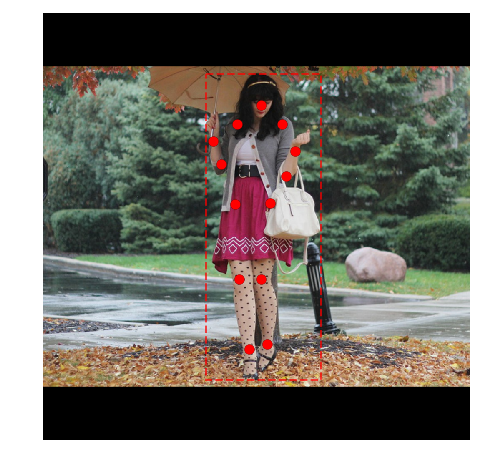

In [5]:
importlib.reload(visualize)

# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = []
for i in range(gt_kp_masks.shape[0]):
    msks = []
    for j in range(gt_kp_masks.shape[1]):
        mask = np.zeros((image.shape[:2]), dtype=np.bool)
        k = gt_kp_masks[i, j]
        mask[k // mask.shape[1], k % mask.shape[1]] = True
        msks.append(mask)
    masks.append(msks)
masks = np.array(masks)
    
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            #skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
mrcnn_mask.shape (1, 100, 13, 28, 28)
mrcnn_mask.dtype float32
detections.shape (100, 6)
mrcnn_mask.shape (100, 13, 28, 28)
masks.shape (94, 13, 28, 28)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
class_ids                shape: (94,)                 min:    1.00000  max:    1.00000  int32
kp_ids                   shape: (12, 17)              min:    0.00000  max:   16.00000  int64
bbox                     shape: (94, 4)               min:  132.00000  max:  905.00000  int32
masks                    shape: (94, 13, 1024, 1024)  min:    0.00000  

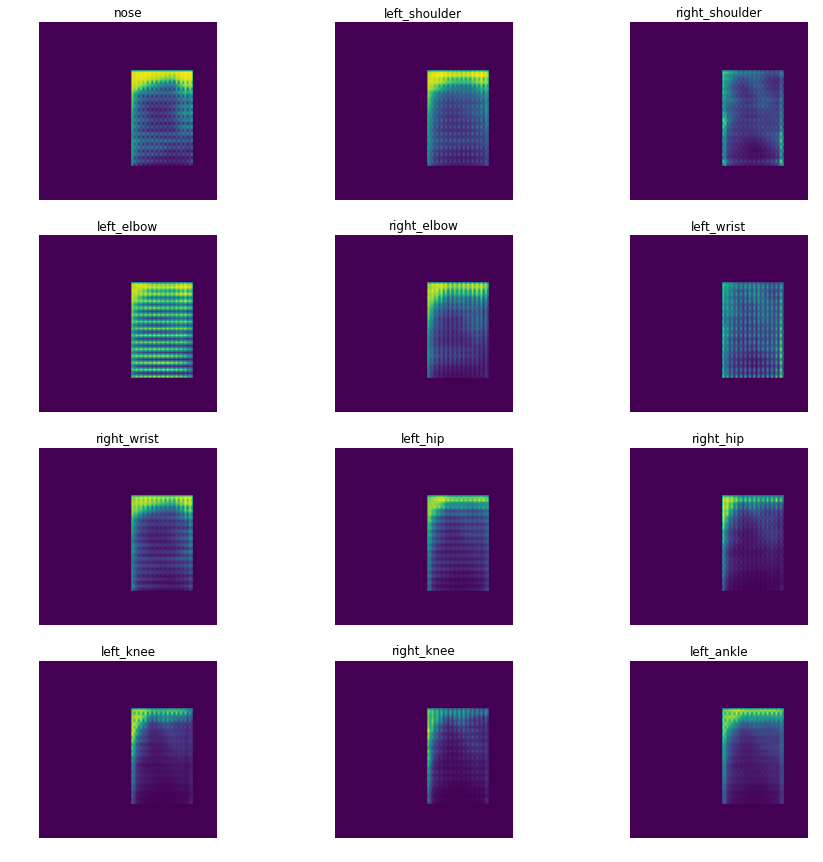

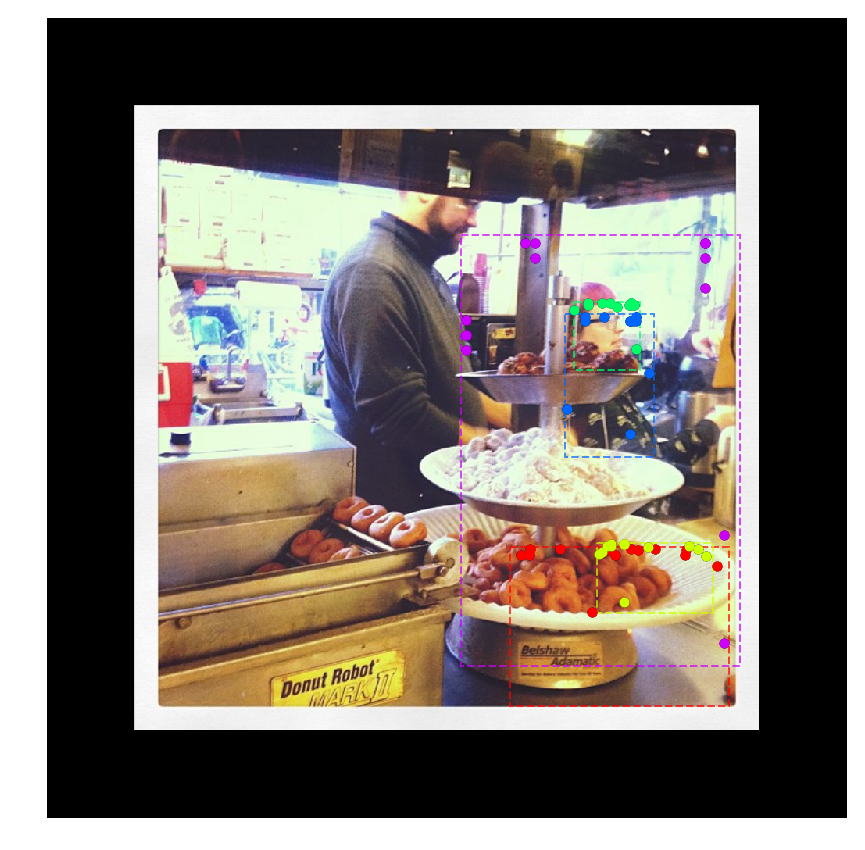

In [6]:
importlib.reload(modellib)

# Load a test image
image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image = modellib.load_image_gt(dataset_val, inference_config, image_id)[0]

results = model.detect([image], verbose=1)
r = results[0]

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(kp_masks[0, i])


plt.show()

visualize.display_keypoints(image, bbox[0:5], kp_masks[0:5],
                            #skeleton=dataset_train.skeleton
                            figsize=(15, 15))

In [ ]:
print(r['class_ids'])
print(r["scores"])

In [ ]:
#visualize.display_keypoints(original_image, r['rois'], r['masks'], r['class_ids'],
#                            dataset_val.class_names, skeleton=None)

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
#print(det_class_ids)
#det_count = np.where(det_class_ids == 0)[0][0]
#det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
"""det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)"""

In [ ]:
#visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")